In [1]:
import io
import time
import gzip

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(4 * 4 * 64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

### some handy functions

In [4]:
def parse_image(file_path):
    if file_path.endswith(".gz"):
        file_handler = gzip
    else:
        file_handler = io
    with file_handler.open(file_path, 'rb') as file_stream:
        parsed_magic_number = int(file_stream.read(4).hex(), 16)
        expected_magic_number = 0x00000803
        if expected_magic_number == parsed_magic_number:
            count = int(file_stream.read(4).hex(), 16)
            row_count = int(file_stream.read(4).hex(), 16)
            col_count = int(file_stream.read(4).hex(), 16)
            return np.frombuffer(file_stream.read(count * row_count * col_count), dtype=np.uint8).reshape(count, row_count, col_count)
        else:
            print("magic number mismatch, expected: {}, got: {}".format(expected_magic_number, parsed_magic_number))


def parse_label(file_path):
    if file_path.endswith(".gz"):
        file_handler = gzip
    else:
        file_handler = io
    with file_handler.open(file_path, 'rb') as file_stream:
        parsed_magic_number = int(file_stream.read(4).hex(), 16)
        expected_magic_number = 0x00000801
        if expected_magic_number == parsed_magic_number:
            count = int(file_stream.read(4).hex(), 16)
            return np.frombuffer(file_stream.read(count), dtype=np.uint8)
        else:
            print("magic number mismatch, expected: {}, got: {}".format(expected_magic_number, parsed_magic_number))


def shuffle(x, y):
    assert x.shape[0] == y.shape[0]
    permute = np.random.permutation(x.shape[0])
    return x[permute], y[permute]


def train(model, optimizer, device, x_train, y_train, BATCH_SIZE=1000, EPOCH_SIZE=32):
    x_train = torch.as_tensor(x_train, dtype=torch.float).reshape(-1, 1, 28, 28)
    y_train = torch.as_tensor(y_train, dtype=torch.long)
    model.train()
    print("Training")
    for epoch_idx in range(EPOCH_SIZE):
        start_time = time.time()
        x_train, y_train = shuffle(x_train, y_train)
        x_train_shape_0 = x_train.shape[0]
        for batch_start_idx in range(0, x_train_shape_0, BATCH_SIZE):
            batch_end_idx = min(batch_start_idx + BATCH_SIZE, x_train_shape_0)
            
            device_x_train = x_train[batch_start_idx : batch_end_idx].to(device)
            device_y_train = y_train[batch_start_idx : batch_end_idx].to(device)
            optimizer.zero_grad()
            output = model(device_x_train)
            loss = F.nll_loss(output, device_y_train)
            loss.backward()
            optimizer.step()
        print("{0:2d}: loss = {1:8.4f},  {2:10.4f}s".format(epoch_idx, loss.item(), time.time() - start_time))


def evaluate(model, device, x_test, y_test, BATCH_SIZE=1000):
    x_test = torch.as_tensor(x_test, dtype=torch.float).reshape(-1, 1, 28, 28)
    y_test = torch.as_tensor(y_test, dtype=torch.long)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        start_time = time.time()
        x_test, y_test = shuffle(x_test, y_test)
        x_test_shape_0 = x_test.shape[0]
        for batch_start_idx in range(0, x_test_shape_0, BATCH_SIZE):
            batch_end_idx = min(batch_start_idx + BATCH_SIZE, x_test_shape_0)
            
            device_x_test = x_test[batch_start_idx : batch_end_idx].to(device)
            device_y_test = y_test[batch_start_idx : batch_end_idx].to(device)
            output = model(device_x_test)
            total_loss += F.nll_loss(output, device_y_test, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += prediction.eq(device_y_test.view_as(prediction)).sum().item()
        print("Test: {}/{} = {:.4f}, {:.4f}, {:.4f}s".format(
                                                        correct, batch_end_idx, correct / batch_end_idx,
                                                        total_loss / batch_end_idx, time.time() - start_time))


def predict(model, device, x, num=3):
    x = torch.as_tensor(x, dtype=torch.float).reshape(-1, 1, 28, 28).to(device)
    model.eval()
    with torch.no_grad():
        output = model(x)
        for _x, _output in zip(x, output):
            show_img(_x[0].cpu())
            results = []
            for _, confidence, index in zip(range(num), *torch.sort(_output, descending=True)):
                results.append('{:1d}: {:.3f}'.format(index, confidence))
            print(', '.join(results))


def show_img(x):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x, cmap=plt.cm.binary)
    plt.show()


def predict_random_samples(model, device, x, y, row=1, col=4, num=3):
    model.eval()
    plt.figure(figsize=(15, 8))
    with torch.no_grad():
        size = min(x.shape[0], row * col)
        permute = np.random.randint(x.shape[0] - 1, size=size)
        x = x[permute].reshape(-1, 1, 28, 28)
        y = y[permute]
        output = model(torch.as_tensor(x, dtype=torch.float).to(device))
        for idx, _x, _y, _output in zip(range(1, size + 1), x, y, output):
            result = []
            for _, c, l in zip(range(num), *torch.sort(_output, descending=True)):
                result.append('{:1d}: {:.2f}'.format(l, c))
            plt.subplot(row, col, idx)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(_x[0], cmap=plt.cm.binary)
            plt.xlabel('[{}]\n(expected: {})'.format(', '.join(result), _y))
    plt.show()


def save_model(model, name='model.pt'):
    torch.save(model.state_dict(), name)


def print_cuda_mem():
    print("CUDA:0 - {:8.6f} GB".format(torch.cuda.memory_allocated()/2**(10*3)))

## MNIST

In [5]:
# load mnist dataset
mnist_x_train = parse_image('../input/mnist-database-of-handwritten-digits/train-images-idx3-ubyte/train-images-idx3-ubyte')
mnist_y_train = parse_label('../input/mnist-database-of-handwritten-digits/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
mnist_x_test  = parse_image('../input/mnist-database-of-handwritten-digits/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
mnist_y_test  = parse_label('../input/mnist-database-of-handwritten-digits/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [6]:
mnist_num_class = 10
mnist_model = NeuralNet(mnist_num_class).to(device)
mnist_optimizer = optim.Adadelta(params=mnist_model.parameters(), lr=0.01)

train(mnist_model, mnist_optimizer, device, mnist_x_train, mnist_y_train, BATCH_SIZE=1000, EPOCH_SIZE=32)
evaluate(mnist_model, device, mnist_x_test, mnist_y_test)

Training
 0: loss =   0.3961,      1.7458s
 1: loss =   0.2373,      0.9503s
 2: loss =   0.1590,      0.9596s
 3: loss =   0.1688,      0.9510s
 4: loss =   0.2185,      0.9494s
 5: loss =   0.0847,      0.9461s
 6: loss =   0.0765,      0.9457s
 7: loss =   0.0694,      0.9911s
 8: loss =   0.0650,      0.9643s
 9: loss =   0.0935,      0.9541s
10: loss =   0.0488,      0.9544s
11: loss =   0.0604,      0.9569s
12: loss =   0.0502,      0.9507s
13: loss =   0.0378,      0.9960s
14: loss =   0.0489,      0.9521s
15: loss =   0.0305,      0.9652s
16: loss =   0.0290,      0.9489s
17: loss =   0.0401,      0.9527s
18: loss =   0.1135,      0.9551s
19: loss =   0.0325,      0.9445s
20: loss =   0.0159,      0.9561s
21: loss =   0.0228,      0.9478s
22: loss =   0.0203,      0.9449s
23: loss =   0.0189,      0.9445s
24: loss =   0.0346,      0.9511s
25: loss =   0.0240,      0.9716s
26: loss =   0.0308,      0.9479s
27: loss =   0.0178,      0.9482s
28: loss =   0.0138,      0.9449s
29: l

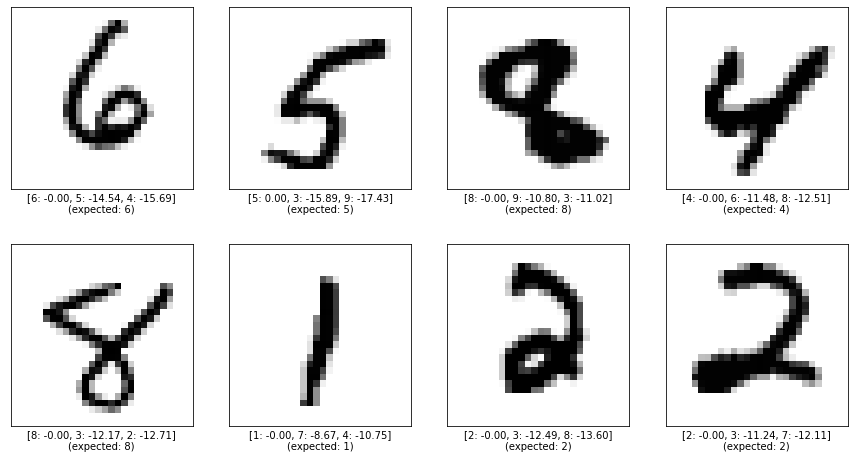

In [7]:
# predict some random samples from test set
# then print top results(label and confidence) with expected labels
predict_random_samples(mnist_model, device, mnist_x_test, mnist_y_test, 2, 4)

In [8]:
save_model(mnist_model, 'mnist_model.pt')

## EMNIST

In [9]:
# load emnist dataset
emnist_x_train = parse_image('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-train-images-idx3-ubyte.gz')
emnist_y_train = parse_label('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-train-labels-idx1-ubyte.gz')
emnist_x_test  = parse_image('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-test-images-idx3-ubyte.gz')
emnist_y_test  = parse_label('../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-test-labels-idx1-ubyte.gz')

# get emnist_num_class
wc_num_lines = !wc --lines '../input/emnist-database-of-handwritten-characters/gzip/gzip/emnist-digits-mapping.txt'
emnist_num_class = int(wc_num_lines[0].split()[0])

# we are transposing each element, because we are reading row-wise(as per mnist) but emnist is stored as col-wise
emnist_x_train = np.transpose(emnist_x_train, (0, 2, 1))
emnist_x_test  = np.transpose(emnist_x_test , (0, 2, 1))

emnist_model = NeuralNet(emnist_num_class).to(device)
emnist_optimizer = optim.Adadelta(params=emnist_model.parameters(), lr=0.01)

train(emnist_model, emnist_optimizer, device, emnist_x_train, emnist_y_train, BATCH_SIZE=1000, EPOCH_SIZE=32)
evaluate(emnist_model, device, emnist_x_test, emnist_y_test)

Training
 0: loss =   0.1269,      3.8301s
 1: loss =   0.0510,      3.8247s
 2: loss =   0.0509,      3.8032s
 3: loss =   0.0394,      3.8228s
 4: loss =   0.0332,      3.8248s
 5: loss =   0.0557,      3.8077s
 6: loss =   0.0303,      3.7995s
 7: loss =   0.0282,      3.7905s
 8: loss =   0.0164,      3.8769s
 9: loss =   0.0123,      3.9004s
10: loss =   0.0103,      3.9011s
11: loss =   0.0268,      3.8021s
12: loss =   0.0266,      3.8369s
13: loss =   0.0076,      3.8152s
14: loss =   0.0157,      3.8060s
15: loss =   0.0098,      3.7951s
16: loss =   0.0152,      3.7972s
17: loss =   0.0095,      3.8010s
18: loss =   0.0199,      3.7997s
19: loss =   0.0067,      3.8187s
20: loss =   0.0061,      3.8049s
21: loss =   0.0094,      3.8137s
22: loss =   0.0144,      3.8550s
23: loss =   0.0153,      3.8095s
24: loss =   0.0126,      3.8393s
25: loss =   0.0049,      3.9055s
26: loss =   0.0058,      3.8345s
27: loss =   0.0078,      3.8170s
28: loss =   0.0104,      3.7971s
29: l

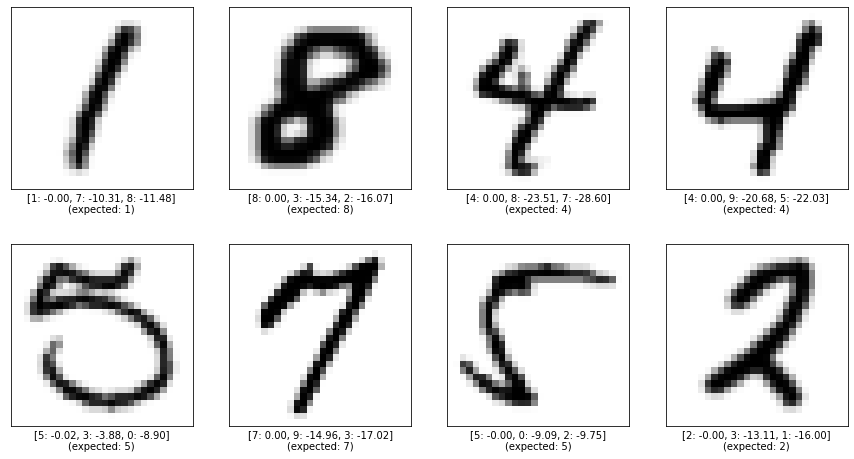

In [10]:
predict_random_samples(emnist_model, device, emnist_x_test, emnist_y_test, 2, 4)

In [11]:
save_model(emnist_model, 'emnist_model.pt')

## misc

In [12]:
# evaluate mnist_model on emnist dataset
evaluate(mnist_model, device, emnist_x_test, emnist_y_test)

Test: 36555/40000 = 0.9139, 0.3286, 0.2702s


In [13]:
# evaluate emnist_model on mnist dataset
evaluate(emnist_model, device, mnist_x_test, mnist_y_test)

Test: 9683/10000 = 0.9683, 0.0936, 0.0638s
